# Data Querying

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### 0. Initial Setup & Connection

Install the **`google-cloud-bigquery`** library to connect to the public datawarehouse

In [ ]:
!pip install google-cloud-bigquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The following code Authenticates Colab notebook with my Google Cloud account

In [ ]:
from google.colab import auth
auth.authenticate_user()

Create a client object for the BigQuery API


---


We need to create a client object for the project that is associated with the dataset. In this case, the project ID is `eighth-sensor-312121`

In [ ]:
from google.cloud import bigquery

# Create a client object for the San Francisco Bikeshare dataset
client = bigquery.Client(project="eighth-sensor-312121")

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### 1. How many bike trips have been started in `San Jose`?

In [ ]:
# SQL query
query_job = client.query("""
    SELECT COUNT(*) as bikes_trips_san_jose
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE start_station_name = 'San Jose Diridon Caltrain Station'
""")

In [ ]:
# query result
result = query_job.result()

In [ ]:
# Print the result
for row in result:
    print(row[0])

13593


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### 2. Which bike station has the oldest members in average?

To find the bike station with the oldest members on average, I calculated the average age of the members for each station, and then sorted the results in descending order to get the station with the oldest members on average.

In [ ]:
# SQL query
query_job_2 = client.query("""
    SELECT start_station_name as station_name, ROUND(AVG(EXTRACT(YEAR FROM CURRENT_DATE()) - member_birth_year)) AS avg_age
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE start_station_name IS NOT NULL
    GROUP BY start_station_name
    ORDER BY avg_age DESC
    LIMIT 1
""")

In [ ]:
# Query result
result_2 = query_job_2.result()

In [ ]:
# Print the result
for r in result_2:
    print(r.station_name, r.avg_age)

Mission St at 1st St 54.0


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### 3. During which month in 2018 did customers ride the longest per trip?

In [ ]:
# SQL query
query_job_3 = client.query("""
SELECT FORMAT_DATE('%B', start_date) AS month, ROUND(AVG(duration_sec/60)) AS avg_duration_min
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
 WHERE EXTRACT(YEAR FROM start_date) = 2018 AND subscriber_type = 'Customer'
GROUP BY month
ORDER BY avg_duration_min DESC
LIMIT 1
""")

The above query selects the month (Used FORMAT_DATE instead of EXTRACT to get the month name) and the average trip duration (in minutes) for all trips that started in 2018 and had a subscriber type of `'Customer'`. It groups the results by month and sorts them in descending order by the **`avg_duration_min`** column. Finally, it selects the first row using **LIMIT 1**, which corresponds to the month with the longest average trip duration

In [ ]:
# Query result
result_3 = query_job_3.result()

In [ ]:
# Print the result
for row in result_3:
    print("Month:", row.month, "Average duration (min):", round(row.avg_duration_min, 2))

Month: January Average duration (min): 39.0


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### 4. What are the top 3 starting stations for customers with a subscription?

In [ ]:
# SQL query
query_job_4 = client.query("""
    SELECT start_station_name, COUNT(*) AS num_trips
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE subscriber_type = 'Subscriber'
    GROUP BY start_station_name
    ORDER BY num_trips DESC
    LIMIT 3
""")

In [ ]:
# get query result
result_4 = query_job_4.result()

# print query result
for row in result_4:
    print("Starting station:", row.start_station_name, ", ", "Number of trips:", row.num_trips)


Starting station: San Francisco Caltrain (Townsend St at 4th St) ,  Number of trips: 20416
Starting station: San Francisco Caltrain Station 2  (Townsend St at 4th St) ,  Number of trips: 18581
Starting station: Market St at 10th St ,  Number of trips: 18005


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### 5. What is the average time difference between start dates of bike trips for the station “SAP Center”?

In [ ]:
# SQL query
query_job_5 = client.query("""
    WITH sap_center_trips AS (
      SELECT 
        start_station_name,
        start_date,
        LAG(start_date) OVER (ORDER BY start_date) AS prev_start_date
      FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
      WHERE start_station_name = 'SAP Center'
    )
    SELECT AVG(TIMESTAMP_DIFF(start_date, prev_start_date, SECOND)) AS avg_time_diff
    FROM sap_center_trips
    WHERE prev_start_date IS NOT NULL
""")

The SQL query selects the start dates of all trips that started at **SAP Center**, calculates the time difference between consecutive trips using the **`LAG()`** function, and then calculates the average time difference using the **`AVG()`** function.

In [ ]:
# query result
result_5 = query_job_5.result()

# Print result
for row in result_5:
    print("Average time difference:", row.avg_time_diff/60, "seconds")

Average time difference: 683.2937362030904 seconds


# Data Visualization

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### 1. By plotting a chart, how is the bike share business in San Francisco performing over time?

In [ ]:
#import libraries for data visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as ny
import plotly.express as px
%matplotlib inline
import seaborn as sns

The SQL query below retrieves the number of bike trips over the last 3 years in the data (2016 to 2018). The result is then plotted using Matplotlib.

In [ ]:
#SQL query
query_6 = """
    SELECT 
      EXTRACT(YEAR FROM start_date) AS year,
      EXTRACT(MONTH FROM start_date) AS month,
      COUNT(*) AS num_trips
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE EXTRACT(YEAR FROM start_date) BETWEEN 2016 AND 2018
    GROUP BY year, month
    ORDER BY year ASC, month ASC
"""

In [ ]:
# query result
query_job_6 = client.query(query_6)
result_6 = query_job_6.result()

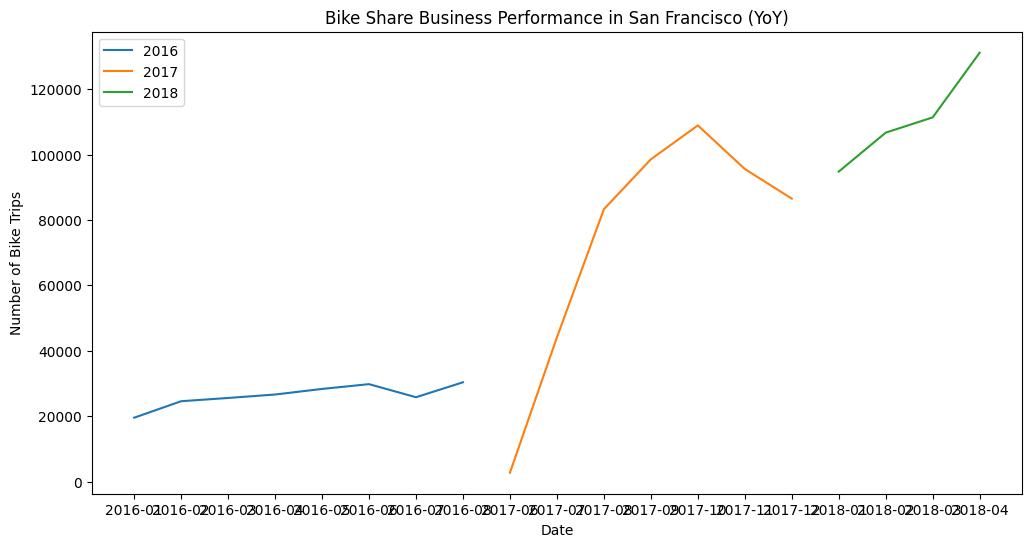

In [ ]:
# Create a dictionary to store the year-month data and the number of trips
data_dict = {}

# Iterate through the query result and populate the dictionary
for row in result_6:
    year = row.year
    month = row.month
    date_str = f"{year}-{month:02d}"
    num_trips = row.num_trips
    if year not in data_dict:
        data_dict[year] = {}
    data_dict[year][date_str] = num_trips

# Create a line chart using Matplotlib
plt.figure(figsize=(12,6))
for year in sorted(data_dict.keys()):
    x_data = list(data_dict[year].keys())
    y_data = list(data_dict[year].values())
    plt.plot(x_data, y_data, label=f"{year}")
plt.xlabel("Date")
plt.ylabel("Number of Bike Trips")
plt.title("Bike Share Business Performance in San Francisco (YoY)")
plt.legend()
plt.show()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### 2. Observations between bike share users in **San Franciso** & **New York**

1.   **Bike Share Trips:**
In both cities, the majority of trips are relatively short, with an average duration of around 16 minutes. However, New York City has a higher percentage of longer trips, with more trips lasting over 30 minutes than in San Francisco.
This could be due to the difference in bike infrastructure between the two cities, with New York City having a larger network of protected bike lanes and bike-friendly streets, coupled with that fact that it has more bike stations ~x2 compared to San Francisco.

2.   **User Demographics:**
Both cities have a similar percentage of male users, with San Francisco having 77% male users and New York City having 75% male users. However, there is a significant difference in age demographics, with San Francisco having a higher percentage of users in the 18-34 age range (55%) compared to New York City (50%). 
This could be due to the fact that San Francisco has a younger overall population than New York City.

3.   **Popular Stations:**
The most popular bike share stations in both cities are located in the downtown areas and near popular tourist attractions. However, San Francisco has a smaller number of stations overall (512) compared to New York City (1900+), which could lead to more crowded and less available bikes during peak times.

Note: Refer to data discovery graphs section below for relavant data insights to support the above observations

# Data Discovery Graphs

### **::San Francisco::**

> SQL & Python codes to validate observations



**Popular Stations**

There are 512 bike share stations in the dataset, with 3 clusters 2 of which is located in the North West area of the map *(Further research showed that they are located in the downtown areas and near popular tourist attractions)*


In [ ]:
# Query to get bike share station locations
sql = """
    SELECT
        station_id,
        name,
        lat,
        lon
    FROM
        `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info`
"""

In [ ]:
# Make the API request to get the station data
df = client.query(sql).to_dataframe()

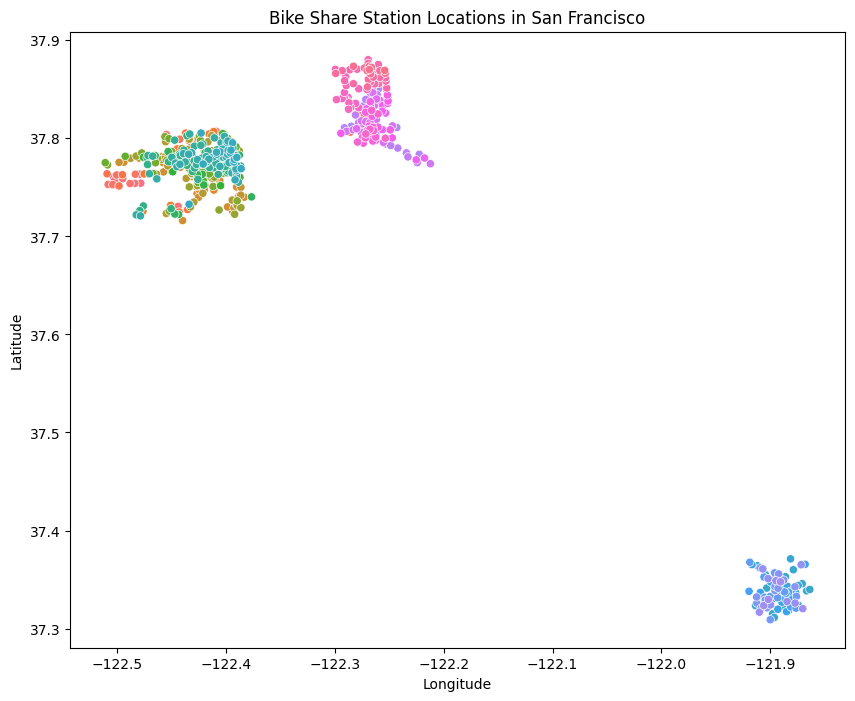

In [ ]:
# Create a scatter plot of the station locations
plt.figure(figsize=(10, 8))
sns.scatterplot(x='lon', y='lat', data=df, hue='name', legend=False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bike Share Station Locations in San Francisco')
plt.show()

In other to drill further to better undertand the clusters and density distribution. I used a light wieght map plugin - folium which very interactive

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Create a map centered at the mean of the station locations
map_ny = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=9)

# Add markers to the map for each station
marker_cluster = MarkerCluster().add_to(map_ny)
for index, row in df.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], popup=row['name']).add_to(marker_cluster)

# Display the map
map_ny

**User Demographics**

The majority of bike share users are male (approx. 77%) with 55% middle aged (beawtween the ages of 34 and 50)

In [ ]:
# SQL query to extract the gender of bike share subscribers
users_distribution = """
SELECT member_gender AS gender, COUNT(*) AS count
FROM`bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
WHERE subscriber_type = 'Subscriber' AND member_gender IS NOT NULL
GROUP BY gender
"""

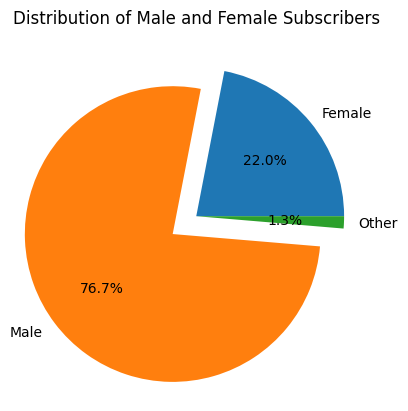

In [ ]:
# Execute query and convert the result to a Pandas DataFrame
users_distribution_result = client.query(users_distribution).to_dataframe()

# Plot the result as a pie chart
plt.pie(users_distribution_result['count'], labels = users_distribution_result['gender'], autopct='%1.1f%%', explode = [0, 0.2, 0])
plt.title('Distribution of Male and Female Subscribers')
plt.show()

In [ ]:
# SQL query to extract the age distribution of male subscribers
users_distribution_2 = """
WITH MALE_AGE AS (
       SELECT EXTRACT(YEAR FROM CURRENT_DATE()) - member_birth_year AS age
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
WHERE subscriber_type = 'Subscriber' AND member_gender = 'Male' AND member_birth_year IS NOT NULL
)

SELECT 
(CASE WHEN age >= 18 AND age <= 34 THEN "Young Adults"
     WHEN age > 34 AND age <= 50 THEN "Middle Age"
     WHEN age > 50 AND age <= 100 THEN "Old Age"
     ELSE "Ungrouped"
     END)
     AS age_group,
     COUNT(*) AS age_count
     FROM MALE_AGE
     GROUP BY 1
     ORDER BY 2 DESC
"""

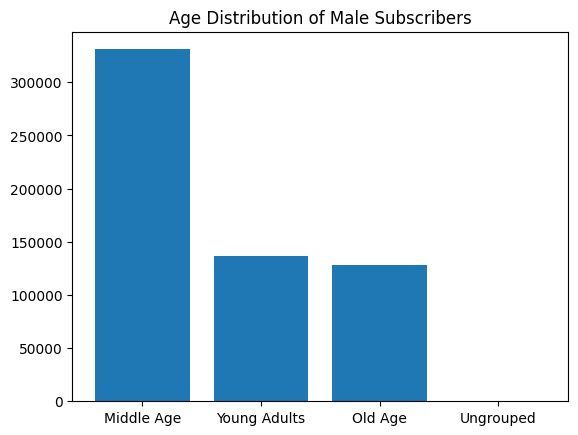

In [ ]:
# Execute query and convert the result to a Pandas DataFrame
users_distribution_result_2 = client.query(users_distribution_2).to_dataframe()

# Plot the result as a pie chart
plt.bar(users_distribution_result_2['age_group'], users_distribution_result_2['age_count'])
plt.title('Age Distribution of Male Subscribers')
plt.show()

**Bike share trips**

The number of bike share trips has increased steadily over the years, with a significant increase in 2018.

In [ ]:
# query to get the number of bike share trips per year
sf_bike_share_trips = """
        SELECT EXTRACT(YEAR FROM start_date) AS year, COUNT(*) AS num_trips
        FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
        GROUP BY year
        ORDER BY year
        """

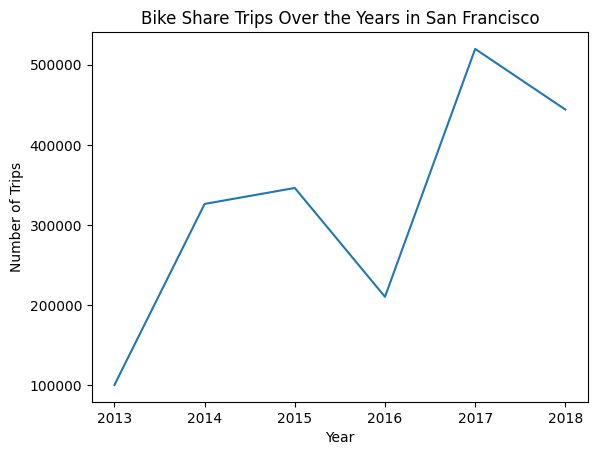

In [ ]:
# execute query and convert results to a pandas dataframe
sf_bike_share_trips_result = client.query(sf_bike_share_trips).result().to_dataframe()

# plot the results using matplotlib
plt.plot(sf_bike_share_trips_result['year'], sf_bike_share_trips_result['num_trips'])
plt.title('Bike Share Trips Over the Years in San Francisco')
plt.xlabel('Year')
plt.ylabel('Number of Trips')
plt.show()

Calcuting average bike share trips for the past 6 years (2013 - 2018)

In [ ]:
sf_avg_trips = """
SELECT AVG(duration_sec)/60 AS avg_trip_duration_min
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
"""

In [ ]:
# runquery
sf_avg_trips_result = client.query(sf_avg_trips).result().to_dataframe()

In [ ]:
# print the results
print("Average trip duration in San Francisco: {:.2f} minutes".format(sf_avg_trips_result.iloc[0]['avg_trip_duration_min']))

Average trip duration in San Francisco: 16.80 minutes


### **::New York::**

> SQL & Python codes to validate observations

**Bike share trips**

The number of bike share trips has increased steadily over the years, with a significant increase in 2018.

In [ ]:
ny_trips_query = """
    SELECT EXTRACT(YEAR FROM starttime) AS year, COUNT(*) AS num_trips
    FROM `bigquery-public-data.new_york_citibike.citibike_trips`
    WHERE starttime IS NOT NULL
    GROUP BY year
    ORDER BY year
"""

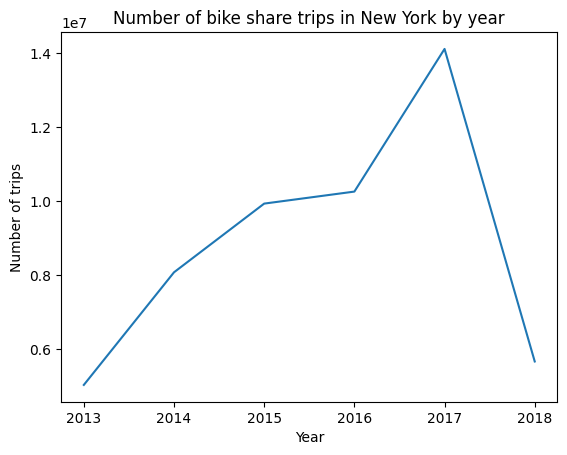

In [ ]:
ny_trips_query_results = client.query(ny_trips_query).to_dataframe()

plt.plot(ny_trips_query_results['year'], ny_trips_query_results['num_trips'])
plt.xlabel('Year')
plt.ylabel('Number of trips')
plt.title('Number of bike share trips in New York by year')
plt.show()

Calcuting average bike share trips for the past 6 years (2013 - 2018)

In [ ]:
nyc_avg_trips = """
SELECT AVG(tripduration)/60 AS avg_trip_duration_min
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
"""

In [ ]:
# run query
nyc_avg_trips_result = client.query(nyc_avg_trips).result().to_dataframe()

In [ ]:
print("Average trip duration in New York City: {:.2f} minutes".format(nyc_avg_trips_result.iloc[0]['avg_trip_duration_min']))

Average trip duration in New York City: 16.04 minutes


**User Demographics**

The majority of bike share users are male (approx. 75%) with 50% middle aged (beawtween the ages of 34 and 50)

In [ ]:
ny_users_query = """
SELECT gender AS gender, COUNT(*) AS count
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE usertype = 'Subscriber' AND gender IS NOT NULL
GROUP BY gender
"""

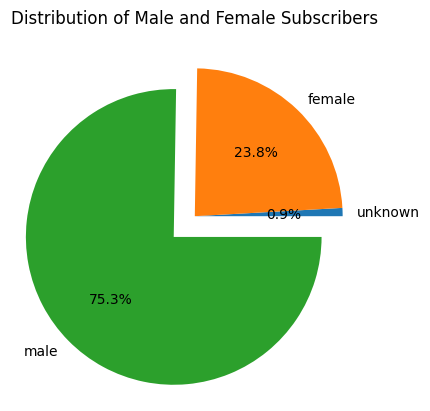

In [ ]:
# Execute query and convert the result to a Pandas DataFrame
ny_users_query_result = client.query(ny_users_query).to_dataframe()

# Plot the result as a pie chart
plt.pie(ny_users_query_result['count'], labels = ny_users_query_result['gender'], autopct='%1.1f%%', explode = [0, 0, 0.2])
plt.title('Distribution of Male and Female Subscribers')
plt.show()

In [ ]:
# SQL query to extract the age distribution of male subscribers
ny_users_distribution = """
WITH MALE_AGE AS (
       SELECT EXTRACT(YEAR FROM CURRENT_DATE()) - birth_year AS age
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE usertype = 'Subscriber' AND gender = 'male' AND birth_year IS NOT NULL
)

SELECT 
(CASE WHEN age >= 18 AND age <= 34 THEN "Young Adults"
     WHEN age > 34 AND age <= 50 THEN "Middle Age"
     WHEN age > 50 AND age <= 100 THEN "Old Age"
     ELSE "Ungrouped"
     END)
     AS age_group,
     COUNT(*) AS age_count
     FROM MALE_AGE
     GROUP BY 1
     ORDER BY 2 DESC
"""

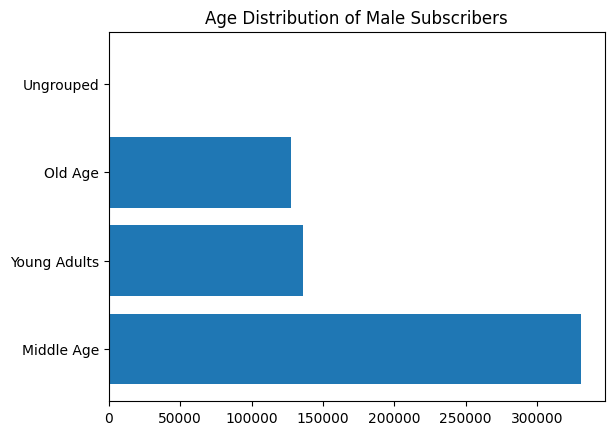

In [ ]:
# Execute query and convert the result to a Pandas DataFrame
ny_users_distribution_result = client.query(ny_users_distribution).to_dataframe()

# Plot the result as a pie chart
# Plot the result as a pie chart
plt.barh(users_distribution_result_2['age_group'], users_distribution_result_2['age_count'])
plt.title('Age Distribution of Male Subscribers')
plt.show()

**Popular Stations**

There are 1910 bike share stations in the dataset, 65% located in Newyork central - West 30th Street Heliport, Manhattan, and around major airports. These are also popular tourist destinations

In [ ]:
# Query to get bike share station locations
ny_stations = """
    SELECT
        station_id,
        name,
        latitude as lat,
        longitude as lon
    FROM
        `bigquery-public-data.new_york_citibike.citibike_stations`
"""

In [ ]:
# Make the API request to get the station data
ny_stations_result = client.query(ny_stations).to_dataframe()

In [ ]:
# Create a map centered at the mean of the station locations
map_ny = folium.Map(location=[ny_stations_result['lat'].mean(), ny_stations_result['lon'].mean()], zoom_start=10)

# Add markers to the map for each station
marker_cluster = MarkerCluster().add_to(map_ny)
for index, row in ny_stations_result.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], popup=row['name']).add_to(marker_cluster)

# Display the map
map_ny